In [14]:
import PIL.Image
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

In [15]:
from sklearn.model_selection import train_test_split
data_train = pd.read_csv('input/fashion-mnist_train.csv')
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size
= 0.3)

In [16]:
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [17]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4243, 4135, 4184, 4237, 4198, 4191, 4226, 4142, 4262, 4182]
test groups: [1757, 1865, 1816, 1763, 1802, 1809, 1774, 1858, 1738, 1818]


In [5]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]

        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            non_group_idx = [np.random.choice([i for i in all_groups if i!= c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

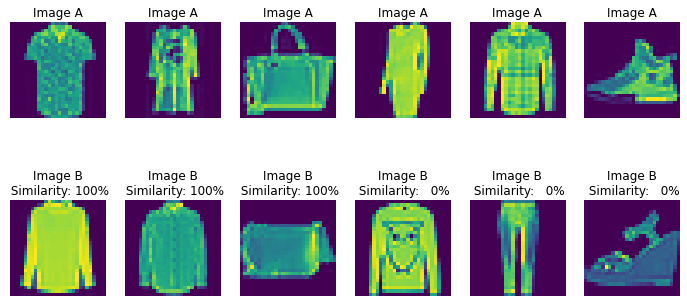

In [6]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [10]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name =
'FeatureGenerationModel')
feature_model.summary()

2023-03-23 17:15:41.879031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 17:15:44.311859: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-23 17:15:44.311902: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-23 17:15:44.312513: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

Model: "FeatureGenerationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureNet_ImageInput (Inpu  [(None, 28, 28, 1)]      0         
 tLayer)                                                         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24,

In [11]:
from keras.layers import concatenate
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name =
'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs =
[combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 32)          25040       ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 64)           0           ['FeatureGeneratio

In [12]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy',
                         metrics = ['mae'])

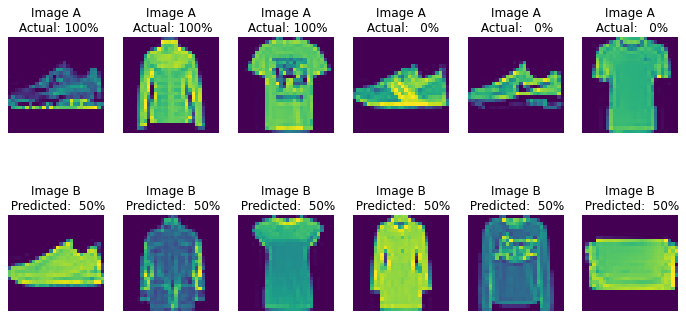

In [13]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim,m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [14]:
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups),
steps_per_epoch = 500,
validation_data=([valid_a, valid_b],
valid_sim),
epochs = 10,
verbose = True)

Epoch 1/10


/tmp/ipykernel_354160/3129498173.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = similarity_model.fit_generator(siam_gen(train_groups),


  3/500 [..............................] - ETA: 30s - loss: 0.7970 - mae: 0.5179

2023-03-23 17:15:50.584072: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18284544 exceeds 10% of free system memory.
2023-03-23 17:15:50.584152: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18284544 exceeds 10% of free system memory.
2023-03-23 17:15:50.584200: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18284544 exceeds 10% of free system memory.
2023-03-23 17:15:50.584261: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18284544 exceeds 10% of free system memory.
2023-03-23 17:15:50.588060: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24768000 exceeds 10% of free system memory.


500/500 [==============================] - 41s 77ms/step - loss: 0.6449 - mae: 0.4580 - val_loss: 0.5003 - val_mae: 0.3671
Epoch 2/10
500/500 [==============================] - 37s 74ms/step - loss: 0.4924 - mae: 0.3489 - val_loss: 0.4219 - val_mae: 0.2871
Epoch 3/10
500/500 [==============================] - 37s 73ms/step - loss: 0.4431 - mae: 0.3024 - val_loss: 0.4011 - val_mae: 0.2611
Epoch 4/10
500/500 [==============================] - 36s 71ms/step - loss: 0.4223 - mae: 0.2813 - val_loss: 0.3743 - val_mae: 0.2458
Epoch 5/10
500/500 [==============================] - 36s 72ms/step - loss: 0.4055 - mae: 0.2691 - val_loss: 0.3528 - val_mae: 0.2213
Epoch 6/10
500/500 [==============================] - 35s 71ms/step - loss: 0.3884 - mae: 0.2545 - val_loss: 0.3415 - val_mae: 0.2261
Epoch 7/10
500/500 [==============================] - 35s 70ms/step - loss: 0.3721 - mae: 0.2425 - val_loss: 0.3345 - val_mae: 0.2101
Epoch 8/10
500/500 [==============================] - 35s 71ms/step - los

In [15]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose =
True, batch_size = 128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose
= True, batch_size = 128)

141/141 [==============================] - 6s 39ms/step


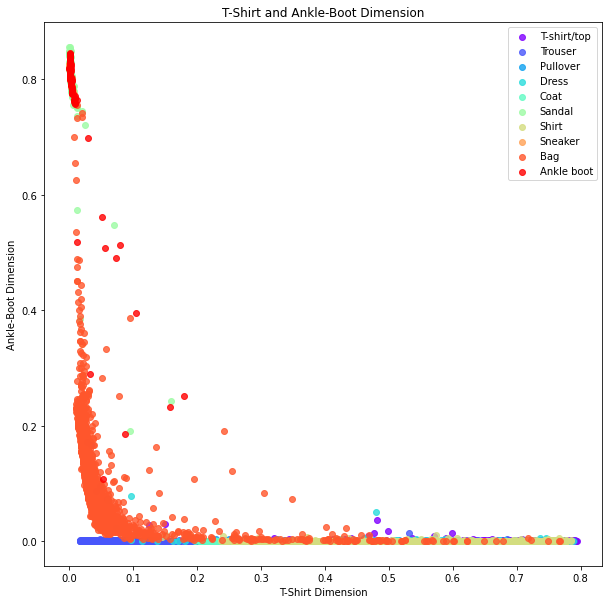

In [16]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(t_shirt_score[np.where(y_test == c_group), 0],ankle_boot_score[np.where(y_test == c_group), 0],color=c_color,linewidth=1,alpha=0.8,label=c_label)
plt.savefig('tshirt-boot-dist.png')
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')

plt.show(block=False)


In [17]:
x_test_features = feature_model.predict(x_test, verbose = True,
batch_size=128)

141/141 [==============================] - 4s 26ms/step


In [18]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
init='pca',
random_state=101,
method='barnes_hut',
n_iter=500,
verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

/home/stepan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.001s...
[t-SNE] Computed neighbors for 18000 samples in 20.222s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sa

/home/stepan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 82.8234406, gradient norm = 0.0021294 (50 iterations in 9.492s)
[t-SNE] Iteration 100: error = 80.7274857, gradient norm = 0.0010922 (50 iterations in 9.523s)
[t-SNE] Iteration 150: error = 79.8000031, gradient norm = 0.0007666 (50 iterations in 7.955s)
[t-SNE] Iteration 200: error = 79.2705688, gradient norm = 0.0005710 (50 iterations in 8.012s)
[t-SNE] Iteration 250: error = 78.9287033, gradient norm = 0.0004610 (50 iterations in 8.315s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.928703
[t-SNE] Iteration 300: error = 3.2445767, gradient norm = 0.0012357 (50 iterations in 7.632s)
[t-SNE] Iteration 350: error = 2.7304080, gradient norm = 0.0006365 (50 iterations in 7.948s)
[t-SNE] Iteration 400: error = 2.4234524, gradient norm = 0.0004013 (50 iterations in 9.050s)
[t-SNE] Iteration 450: error = 2.2279253, gradient norm = 0.0002835 (50 iterations in 8.644s)
[t-SNE] Iteration 500: error = 2.0925214, gradient norm = 0.0002141 (50 

In [19]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

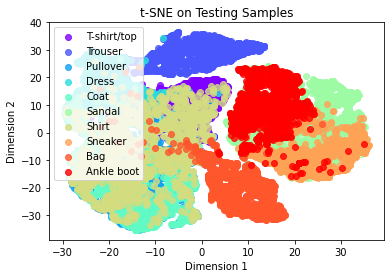

In [20]:
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],tsne_features[np.where(y_test == c_group), 1],marker='o',color=c_color,linewidth=1,alpha=0.8,label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)

In [62]:
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, Activation, BatchNormalization, Input
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

# input layer and batch normalization
inputLayer = Input(shape=(299, 299, 3))
ResNetModel = BatchNormalization() (inputLayer)

# pre-trained model from keras applications library
ResNetModel = InceptionResNetV2(weights='imagenet', input_shape=(28, 28, 3), include_top=False)(ResNetModel)


ValueError: Input size must be at least 75x75; Received: input_shape=(28, 28, 3)

In [ ]:

# extra convolutional layer
ResNetModel = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(ResNetModel)

# Flatten and pass into a densely connected layer
ResNetModel = Flatten()(ResNetModel)
ResNetModel = Dropout(0.5)(ResNetModel)

ResNetModel = Dense(512, activation='relu')(ResNetModel)
ResNetModel = Dropout(0.5)(ResNetModel)

# output
ResNetModel = Dense(28, activation='sigmoid')(ResNetModel)
ResNetModel = Model(inputLayer, ResNetModel)


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import itertools
#import shutil
from tqdm import tqdm
%matplotlib inline

In [ ]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is ‘channel_last’
    h, w = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, w - dx + 1)
    y = np.random.randint(0, h - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]
def crop_generator(batches, crop_length):
    sz = crop_length
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], sz, sz, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (sz,sz))
        yield (batch_crops, batch_y)

tr_datagen =  ImageDataGenerator(rescale=1.0/255,
                                 horizontal_flip=True,
                                 vertical_flip=True)
ts_datagen = ImageDataGenerator(rescale=1.0/255)
train_gen = tr_datagen.flow_from_directory('input/fashion-mnist_test.csv',
                                target_size=(75,75),
                                batch_size=20,
                                class_mode='categorical')
tr_crops = crop_generator(train_gen)
val_gen = val_datagen.flow_from_directory(valid_path,
                               target_size=(IMAGE_SIZE,IMAGE_SIZE),
                               batch_size=val_batch_size,
                               class_mode=’categorical’)
val_crops = crop_generator(val_gen)
#Note: shuffle=False causes the test dataset to not be shuffled
test_gen = ts_datagen.flow_from_directory(test_path,
                               target_size=(IMAGE_SIZE,IMAGE_SIZE),
                               batch_size=1,
                               class_mode=’categorical’,
                               shuffle=False)
#ts_crops = crop_generator(test_gen)

In [138]:
import numpy as np

# Assume x_train is a numpy array of shape (num_images, 28, 28, num_channels)
num_images = x_train.shape[0]
num_channels = x_train.shape[-1]

# Create a new numpy array for the resized images
x_train_resized = np.zeros((num_images, 75, 75))
y_train_resized0 = np.zeros((num_images))
print(num_images)
# Loop through each image in x_train and resize it
for i in tqdm(range(num_images)):
    x_train_resized[i] = cv2.resize(x_train[i], (75, 75))
for i in tqdm(range(num_images)):
    y_train_resized0[i] = y_train[i]
y_train_resized = to_categorical(y_train_resized0)

42000


100%|██████████| 42000/42000 [00:00<00:00, 1416288.27it/s]


In [141]:
from tensorflow.keras.utils import to_categorical


print(y_train_resized.shape)

(42000, 10)


In [100]:
def conv2d(x,numfilt,filtsz,strides=1,pad='same',act=True,name=None):
  x = Conv2D(numfilt,filtsz,strides,padding=pad,data_format='channels_last',use_bias=False,name=name+'conv2d')(x)
  x = BatchNormalization(axis=3,scale=False,name=name+'conv2d'+'bn')(x)
  if act:
    x = Activation('relu',name=name+'conv2d'+'act')(x)
  return x

In [101]:
def incresA(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,32,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,32,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,32,3,1,pad,True,name=name+'b1_2')
    branch2 = conv2d(x,32,1,1,pad,True,name=name+'b2_1')
    branch2 = conv2d(branch2,48,3,1,pad,True,name=name+'b2_2')
    branch2 = conv2d(branch2,64,3,1,pad,True,name=name+'b2_3')
    branches = [branch0,branch1,branch2]
    mixed = Concatenate(axis=3, name=name + '_concat')(branches)
    filt_exp_1x1 = conv2d(mixed,384,1,1,pad,False,name=name+'filt_exp_1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return final_lay

In [102]:
def incresB(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,192,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,128,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,160,[1,7],1,pad,True,name=name+'b1_2')
    branch1 = conv2d(branch1,192,[7,1],1,pad,True,name=name+'b1_3')
    branches = [branch0,branch1]
    mixed = Concatenate(axis=3, name=name + '_mixed')(branches)
    filt_exp_1x1 = conv2d(mixed,1152,1,1,pad,False,name=name+'filt_exp_1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return final_lay

In [103]:
def incresC(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,192,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,192,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,224,[1,3],1,pad,True,name=name+'b1_2')
    branch1 = conv2d(branch1,256,[3,1],1,pad,True,name=name+'b1_3')
    branches = [branch0,branch1]
    mixed = Concatenate(axis=3, name=name + '_mixed')(branches)
    filt_exp_1x1 = conv2d(mixed,2048,1,1,pad,False,name=name+'fin1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_saling')([x, filt_exp_1x1])
    return final_lay

In [145]:
img_input = Input(shape=(75,75,1))

x = conv2d(img_input,32,3,2,'valid',True,name='conv1')
x = conv2d(x,32,3,1,'valid',True,name='conv2')
x = conv2d(x,64,3,1,'valid',True,name='conv3')

x_11 = MaxPooling2D(3,strides=1,padding='valid',name='stem_br_11'+'_maxpool_1')(x)
x_12 = conv2d(x,64,3,1,'valid',True,name='stem_br_12')

x = Concatenate(axis=3, name = 'stem_concat_1')([x_11,x_12])

x_21 = conv2d(x,64,1,1,'same',True,name='stem_br_211')
x_21 = conv2d(x_21,64,[1,7],1,'same',True,name='stem_br_212')
x_21 = conv2d(x_21,64,[7,1],1,'same',True,name='stem_br_213')
x_21 = conv2d(x_21,96,3,1,'valid',True,name='stem_br_214')

x_22 = conv2d(x,64,1,1,'same',True,name='stem_br_221')
x_22 = conv2d(x_22,96,3,1,'valid',True,name='stem_br_222')

x = Concatenate(axis=3, name = 'stem_concat_2')([x_21,x_22])

x_31 = conv2d(x,192,3,1,'valid',True,name='stem_br_31')
x_32 = MaxPooling2D(3,strides=1,padding='valid',name='stem_br_32'+'_maxpool_2')(x)
x = Concatenate(axis=3, name = 'stem_concat_3')([x_31,x_32])

In [146]:
#Inception-ResNet-A modules
x = incresA(x,0.15,name='incresA_1')
x = incresA(x,0.15,name='incresA_2')
x = incresA(x,0.15,name='incresA_3')
x = incresA(x,0.15,name='incresA_4')

#35 × 35 to 17 × 17 reduction module.
x_red_11 = MaxPooling2D(3,strides=2,padding='valid',name='red_maxpool_1')(x)

x_red_12 = conv2d(x,384,3,2,'valid',True,name='x_red1_c1')

x_red_13 = conv2d(x,256,1,1,'same',True,name='x_red1_c2_1')
x_red_13 = conv2d(x_red_13,256,3,1,'same',True,name='x_red1_c2_2')
x_red_13 = conv2d(x_red_13,384,3,2,'valid',True,name='x_red1_c2_3')

x = Concatenate(axis=3, name='red_concat_1')([x_red_11,x_red_12,x_red_13])

#Inception-ResNet-B modules
x = incresB(x,0.1,name='incresB_1')
x = incresB(x,0.1,name='incresB_2')
x = incresB(x,0.1,name='incresB_3')
x = incresB(x,0.1,name='incresB_4')
x = incresB(x,0.1,name='incresB_5')
x = incresB(x,0.1,name='incresB_6')
x = incresB(x,0.1,name='incresB_7')

#17 × 17 to 8 × 8 reduction module.
x_red_21 = MaxPooling2D(3,strides=2,padding='valid',name='red_maxpool_2')(x)

x_red_22 = conv2d(x,256,1,1,'same',True,name='x_red2_c11')
x_red_22 = conv2d(x_red_22,384,3,2,'valid',True,name='x_red2_c12')

x_red_23 = conv2d(x,256,1,1,'same',True,name='x_red2_c21')
x_red_23 = conv2d(x_red_23,256,3,2,'valid',True,name='x_red2_c22')

x_red_24 = conv2d(x,256,1,1,'same',True,name='x_red2_c31')
x_red_24 = conv2d(x_red_24,256,3,1,'same',True,name='x_red2_c32')
x_red_24 = conv2d(x_red_24,256,3,2,'valid',True,name='x_red2_c33')

x = Concatenate(axis=3, name='red_concat_2')([x_red_21,x_red_22,x_red_23,x_red_24])

#Inception-ResNet-C modules
x = incresC(x,0.2,name='incresC_1')
x = incresC(x,0.2,name='incresC_2')
x = incresC(x,0.2,name='incresC_3')

#TOP
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.6)(x)
x = Dense(10, activation='softmax')(x)

In [147]:
model = Model(img_input,x,name='inception_resnet_v2')

In [148]:
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv1conv2d (Conv2D)           (None, 37, 37, 32)   288         ['input_22[0][0]']               
                                                                                                  
 conv1conv2dbn (BatchNormalizat  (None, 37, 37, 32)  96          ['conv1conv2d[0][0]']            
 ion)                                                                                             
                                                                                                  
 conv1conv2dact (Activation)    (None, 37, 37, 32)   0           ['conv1conv2dbn

In [97]:
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

plot_model(model, to_file='model_plot.png',
                  show_shapes=True, show_layer_names=True)

In [149]:
model.compile(Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


filepath = 'model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                        verbose=1, save_best_only=True, mode='max')

/home/stepan/.local/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [151]:
history = model.fit(x_train_resized,y_train_resized,batch_size=32, epochs=2, validation_split=0.2)


Epoch 1/2
1050/1050 [==============================] - 9410s 9s/step - loss: 0.8175 - accuracy: 0.7424 - val_loss: 0.4008 - val_accuracy: 0.8595
Epoch 2/2
1050/1050 [==============================] - 9173s 9s/step - loss: 0.4718 - accuracy: 0.8385 - val_loss: 0.3565 - val_accuracy: 0.8762


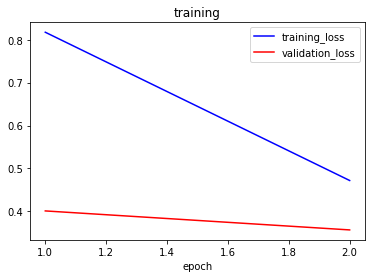

KeyError: 'acc'

In [152]:
# Training plots
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')

plt.show()

plt.plot(epochs, history.history['acc'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_acc'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')

plt.show()

In [163]:
num_images = x_test.shape[0] //10
num_channels = x_test.shape[-1]

# Create a new numpy array for the resized images
x_test_resized = np.zeros((num_images, 75, 75))
y_test_resized0 = np.zeros((num_images))
print(num_images)
# Loop through each image in x_train and resize it
for i in tqdm(range(num_images)):
    x_test_resized[i] = cv2.resize(x_test[i], (75, 75))
for i in tqdm(range(num_images)):
    y_test_resized0[i] = y_test[i]
y_test_resized = to_categorical(y_test_resized0)

1800


100%|██████████| 1800/1800 [00:00<00:00, 1578124.41it/s]


In [164]:
from sklearn.metrics import confusion_matrix

# Predict labels for the test set
y_pred = model.predict(x_test_resized)

# Convert predictions to integer class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to integer class labels
y_true_classes = np.argmax(y_test_resized, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

print(cm)

[[138   0   8   6   2   0  17   0   2   0]
 [  0 169   0   2   3   0   0   0   0   0]
 [  3   0 143   1  24   0   3   0   0   0]
 [  1   0   0 159   9   0   3   0   0   0]
 [  0   0   2   5 166   0   1   0   0   0]
 [  0   0   0   2   0 162   0   6   0   5]
 [ 15   1  21   9  49   0  92   0   0   0]
 [  0   0   0   0   0   1   0 183   0   1]
 [  0   0   1   4   2   0   0   0 194   0]
 [  0   0   0   1   0   1   0   8   0 175]]


In [179]:
# calculate F1 score
from sklearn.metrics import  f1_score, precision_score, recall_score

# calculate precision, recall, and F1 score for each class
precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)


# print confusion matrix and F1 score
print("Confusion matrix:\n", cm)
print("F1 score per class:\n", f1)

Confusion matrix:
 [[138   0   8   6   2   0  17   0   2   0]
 [  0 169   0   2   3   0   0   0   0   0]
 [  3   0 143   1  24   0   3   0   0   0]
 [  1   0   0 159   9   0   3   0   0   0]
 [  0   0   2   5 166   0   1   0   0   0]
 [  0   0   0   2   0 162   0   6   0   5]
 [ 15   1  21   9  49   0  92   0   0   0]
 [  0   0   0   0   0   1   0 183   0   1]
 [  0   0   1   4   2   0   0   0 194   0]
 [  0   0   0   1   0   1   0   8   0 175]]
F1 score per class:
 [0.83636364 0.98255814 0.81948424 0.88088643 0.77389277 0.95575221
 0.60726073 0.95811518 0.97732997 0.95628415]


<AxesSubplot:>

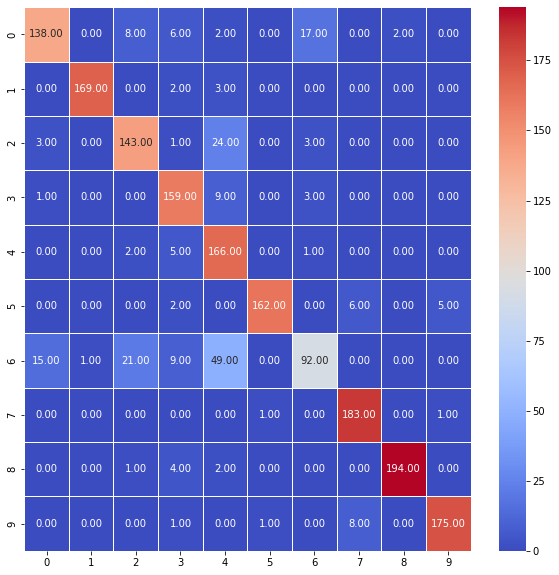

In [182]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.heatmap(cm,cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5)